In [1]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# --- Project Imports ---
from src.data.cmems_dataset import load_cmems_uv, SlidingWindowUVDataset
from src.utils import seed_all

In [2]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# --- Project Imports ---
from src.data.cmems_dataset import load_cmems_uv, SlidingWindowUVDataset
from src.utils import seed_all

# --- Configuration ---
CONFIG = {
    "data_path": "/home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents_uncertainty/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1771446846329.nc", 
    "out_dir": "thesis_experiments",
    "epochs": 100,
    "batch_size": 16,
    "lr": 2e-3,
    "seq_len": 3,
    "base_ch": 32,
    "lstm_ch": 128,
    "seed": 42
}

seed_all(CONFIG['seed'])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
os.makedirs(CONFIG['out_dir'], exist_ok=True)

# --- Z-Score Helper Classes (Defined Here to Ensure Consistency) ---
class ZScoreStats:
    def __init__(self, u_mean, u_std, v_mean, v_std):
        self.u_mean = u_mean
        self.u_std = u_std
        self.v_mean = v_mean
        self.v_std = v_std

def compute_zscore(uv):
    # uv: (T,2,H,W)
    u = uv[:,0]
    v = uv[:,1]
    
    u_mean = np.mean(u)
    u_std  = np.std(u) + 1e-8
    v_mean = np.mean(v)
    v_std  = np.std(v) + 1e-8
    
    return ZScoreStats(u_mean, u_std, v_mean, v_std)

def apply_zscore(uv, stats):
    uv_n = uv.copy()
    uv_n[:,0] = (uv_n[:,0] - stats.u_mean) / stats.u_std
    uv_n[:,1] = (uv_n[:,1] - stats.v_mean) / stats.v_std
    return uv_n

def invert_zscore(uv_n, stats):
    """Converts normalized data back to physical units (m/s)"""
    # Handle both tensor and numpy input
    if isinstance(uv_n, torch.Tensor):
        uv_n = uv_n.detach().cpu().numpy()
        
    uv = uv_n.copy()
    uv[:,0] = uv[:,0] * stats.u_std + stats.u_mean
    uv[:,1] = uv[:,1] * stats.v_std + stats.v_mean
    return uv

Running on: cuda


In [3]:
# --- 1. ConvLSTM Cell ---
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=DEVICE),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=DEVICE))

# --- 2. Thesis Variant Model ---
class ThesisVariant(nn.Module):
    def __init__(self, in_ch, out_ch, base_ch=32, lstm_ch=128, seq_len=3, mode='unet_convlstm'):
        super().__init__()
        self.mode = mode
        self.seq_len = seq_len
        
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, 1, 1), nn.BatchNorm2d(out_c), nn.ReLU(True),
                nn.Conv2d(out_c, out_c, 3, 1, 1), nn.BatchNorm2d(out_c), nn.ReLU(True)
            )
        
        self.inc = double_conv(in_ch, base_ch)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), double_conv(base_ch, base_ch * 2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), double_conv(base_ch * 2, base_ch * 4))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), double_conv(base_ch * 4, base_ch * 8))

        if 'lstm' in mode:
            self.bottleneck = ConvLSTMCell(base_ch * 8, lstm_ch, (3,3), True)
            bot_out_ch = lstm_ch
        else:
            self.bottleneck = double_conv(base_ch * 8, lstm_ch)
            bot_out_ch = lstm_ch

        use_skips = ('unet' in mode)
        self.up1 = UpBlock(bot_out_ch, base_ch * 4, use_skips)
        self.up2 = UpBlock(base_ch * 4, base_ch * 2, use_skips)
        self.up3 = UpBlock(base_ch * 2, base_ch, use_skips)
        self.outc = nn.Conv2d(base_ch, out_ch, 1)

    def forward(self, x):
        if 'lstm' in self.mode:
            b, t, c, h, w = x.shape
            x_flat = x.view(b * t, c, h, w)
            x1 = self.inc(x_flat)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3) 
            
            lstm_in = x4.view(b, t, -1, x4.shape[-2], x4.shape[-1])
            h_state, c_state = self.bottleneck.init_hidden(b, (x4.shape[-2], x4.shape[-1]))
            for t_step in range(t):
                h_state, c_state = self.bottleneck(lstm_in[:, t_step], (h_state, c_state))
            bot_out = h_state
            
            s1 = x1.view(b, t, -1, h, w)[:, -1]
            s2 = x2.view(b, t, -1, h//2, w//2)[:, -1]
            s3 = x3.view(b, t, -1, h//4, w//4)[:, -1]
            
        else:
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            bot_out = self.bottleneck(x4)
            s1, s2, s3 = x1, x2, x3

        x = self.up1(bot_out, s3)
        x = self.up2(x, s2)
        x = self.up3(x, s1)
        return self.outc(x)

class UpBlock(nn.Module):
    def __init__(self, in_c, out_c, use_skips):
        super().__init__()
        self.use_skips = use_skips
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_c + (out_c if use_skips else 0), out_c, 3, 1, 1),
            nn.BatchNorm2d(out_c), nn.ReLU(True),
            nn.Conv2d(out_c, out_c, 3, 1, 1),
            nn.BatchNorm2d(out_c), nn.ReLU(True)
        )
    def forward(self, x1, x2):
        x1 = self.up(x1)
        if self.use_skips:
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]
            x1 = nn.functional.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
            x = torch.cat([x2, x1], dim=1)
        else:
            # FIX: If skips are off, just use the upsampled features
            x = x1 
        return self.conv(x)

In [4]:
def uncertainty_loss(pred_mean, pred_logvar, target):
    sq_diff = (pred_mean - target)**2
    loss = 0.5 * torch.exp(-pred_logvar) * sq_diff + 0.5 * pred_logvar
    return loss.mean()

def train_and_evaluate(mode, train_loader, val_loader, stats, config):
    print(f"\n[{mode.upper()}] Starting Training...")
    
    in_ch = 2 * config['seq_len'] if mode == "standard_unet" else 2
    
    model = ThesisVariant(
        in_ch=in_ch, out_ch=4, 
        base_ch=config['base_ch'], lstm_ch=config['lstm_ch'], 
        seq_len=config['seq_len'], mode=mode
    ).to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    history = []
    
    for epoch in range(1, config['epochs'] + 1):
        model.train()
        total_loss = 0
        
        # Pbar (optional, can remove if too noisy)
        pbar = tqdm(train_loader, desc=f"Ep {epoch}", leave=False)
        for X, Y in pbar:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            
            if mode == "standard_unet":
                b, t, c, h, w = X.shape
                X = X.view(b, t * c, h, w)
                
            optimizer.zero_grad()
            out = model(X)
            pred_mean, pred_logvar = out[:, :2], out[:, 2:]
            
            loss = uncertainty_loss(pred_mean, pred_logvar, Y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            
        # Validation
        val_rmse, val_nll = evaluate(model, val_loader, stats, mode)
        
        history.append({
            "epoch": epoch,
            "val_rmse": val_rmse,
            "val_nll": val_nll,
            "train_loss": total_loss / len(train_loader)
        })
        
        if epoch % 5 == 0:
            print(f"Ep {epoch}: Train Loss={total_loss/len(train_loader):.3f} | Val RMSE={val_rmse:.3f} | Val NLL={val_nll:.3f}")
            
    return history, model

def evaluate(model, loader, stats, mode):
    model.eval()
    rmse_accum = 0
    nll_accum = 0
    count = 0
    
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            if mode == "standard_unet":
                b, t, c, h, w = X.shape
                X = X.view(b, t * c, h, w)
                
            out = model(X)
            pred_mean, pred_logvar = out[:, :2], out[:, 2:]
            
            # NLL (Loss in normalized space)
            loss = uncertainty_loss(pred_mean, pred_logvar, Y)
            nll_accum += loss.item() * X.size(0)
            
            # RMSE (Physical Units - Z-Score Inversion)
            # 1. Invert Prediction
            pred_phys = invert_zscore(pred_mean, stats)
            # 2. Invert Ground Truth
            true_phys = invert_zscore(Y, stats)
            
            # 3. Calculate Speed RMSE
            sq_err = (pred_phys - true_phys)**2
            rmse_accum += np.sqrt(np.mean(sq_err)) * X.size(0)
            count += X.size(0)
            
    return rmse_accum / count, nll_accum / count

In [6]:
# --- Load Data ---
print("Loading dataset...")

# Unpack 4 values
uv_data, time, lat, lon = load_cmems_uv(
    CONFIG["data_path"],
    u_var="utotal",
    v_var="vtotal",
    depth_index=0,
    regrid_hw=(64,64)
)
print(f"Data Shape: {uv_data.shape} (Time, Channels, H, W)")

# --- Split & Normalize (Z-Score) ---
split_t = int(len(uv_data) * 0.8) # 80/20 split
uv_train = uv_data[:split_t]
uv_val   = uv_data[split_t:]

print("Computing Z-Score Stats on Train set...")
stats = compute_zscore(uv_train)
print(f"  U mean={stats.u_mean:.4f}, std={stats.u_std:.4f}")
print(f"  V mean={stats.v_mean:.4f}, std={stats.v_std:.4f}")

# Apply Normalization
uv_train_n = apply_zscore(uv_train, stats)
uv_val_n   = apply_zscore(uv_val,   stats)

# --- Create Datasets ---
train_ds = SlidingWindowUVDataset(uv_train_n, seq_len=CONFIG['seq_len'])
val_ds   = SlidingWindowUVDataset(uv_val_n,   seq_len=CONFIG['seq_len'])

loaders = {
    "train": DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True),
    "val":   DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
}

Loading dataset...
Data Shape: (17545, 2, 64, 64) (Time, Channels, H, W)
Computing Z-Score Stats on Train set...
  U mean=0.0124, std=0.1311
  V mean=-0.0668, std=0.1503


In [4]:
# --- Load Data ---
print("Loading dataset...")

# Unpack 4 values
uv_data, time, lat, lon = load_cmems_uv(
    CONFIG["data_path"],
    u_var="utotal",
    v_var="vtotal",
    depth_index=0,
    regrid_hw=(64,64)
)
print(f"Data Shape: {uv_data.shape} (Time, Channels, H, W)")

# --- Split & Normalize (Z-Score) ---
split_t = int(len(uv_data) * 0.8) # 80/20 split
uv_train = uv_data[:split_t]
uv_val   = uv_data[split_t:]

print("Computing Z-Score Stats on Train set...")
stats = compute_zscore(uv_train)
print(f"  U mean={stats.u_mean:.4f}, std={stats.u_std:.4f}")
print(f"  V mean={stats.v_mean:.4f}, std={stats.v_std:.4f}")

# Apply Normalization
uv_train_n = apply_zscore(uv_train, stats)
uv_val_n   = apply_zscore(uv_val,   stats)

# --- Create Datasets ---
train_ds = SlidingWindowUVDataset(uv_train_n, seq_len=CONFIG['seq_len'])
val_ds   = SlidingWindowUVDataset(uv_val_n,   seq_len=CONFIG['seq_len'])

loaders = {
    "train": DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True),
    "val":   DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
}

# --- Run All Modes ---
results = {}
models = {}
MODES = ["unet_convlstm", "cnn_convlstm", "standard_unet"]

for mode in MODES:
    hist, trained_model = train_and_evaluate(
        mode, loaders["train"], loaders["val"], stats, CONFIG
    )
    results[mode] = hist
    models[mode] = trained_model
    
print("Experiments Complete!")

Loading dataset...
Data Shape: (17545, 2, 64, 64) (Time, Channels, H, W)
Computing Z-Score Stats on Train set...
  U mean=0.0124, std=0.1311
  V mean=-0.0668, std=0.1503

[UNET_CONVLSTM] Starting Training...


Ep 1:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 2:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 4:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 5:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 5: Train Loss=-1.209 | Val RMSE=0.019 | Val NLL=-0.226


Ep 6:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 7:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 8:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 9:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 10:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 10: Train Loss=-1.608 | Val RMSE=0.015 | Val NLL=-1.798


Ep 11:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 12:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 13:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 14:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 15:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 15: Train Loss=-1.778 | Val RMSE=0.063 | Val NLL=-0.921


Ep 16:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 17:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 18:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 19:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 20:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 20: Train Loss=-1.820 | Val RMSE=0.034 | Val NLL=-2.184


Ep 21:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 22:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 23:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 24:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 25:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 25: Train Loss=-2.083 | Val RMSE=0.070 | Val NLL=-0.694


Ep 26:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 27:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 28:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 29:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 30:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 30: Train Loss=-2.037 | Val RMSE=0.035 | Val NLL=-2.033


Ep 31:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 32:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 33:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 34:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 35:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 35: Train Loss=-2.253 | Val RMSE=0.045 | Val NLL=-2.033


Ep 36:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 37:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 38:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 39:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 40:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 40: Train Loss=-2.287 | Val RMSE=0.040 | Val NLL=-2.117


Ep 41:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 42:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 43:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 44:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 45:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 45: Train Loss=-2.316 | Val RMSE=0.048 | Val NLL=-2.381


Ep 46:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 47:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 48:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 49:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 50:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 50: Train Loss=-2.354 | Val RMSE=0.068 | Val NLL=-2.423


Ep 51:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 52:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 53:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 54:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 55:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 55: Train Loss=-2.018 | Val RMSE=0.049 | Val NLL=-2.189


Ep 56:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 57:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 58:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 59:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 60:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 60: Train Loss=-2.362 | Val RMSE=0.059 | Val NLL=-2.342


Ep 61:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 62:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 63:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 64:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 65:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 65: Train Loss=-2.364 | Val RMSE=0.083 | Val NLL=-1.537


Ep 66:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 67:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 68:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 69:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 70:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 70: Train Loss=-2.462 | Val RMSE=0.051 | Val NLL=-2.430


Ep 71:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 72:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 73:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 74:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 75:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 75: Train Loss=-2.241 | Val RMSE=0.088 | Val NLL=-2.504


Ep 76:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 77:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 78:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 79:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 80:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 80: Train Loss=-2.450 | Val RMSE=0.034 | Val NLL=-2.463


Ep 81:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 82:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 83:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 84:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 85:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 85: Train Loss=-2.483 | Val RMSE=0.085 | Val NLL=-2.300


Ep 86:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 87:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 88:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 89:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 90:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 90: Train Loss=-2.544 | Val RMSE=0.061 | Val NLL=-2.411


Ep 91:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 92:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 93:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 94:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 95:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 95: Train Loss=-0.217 | Val RMSE=0.038 | Val NLL=-1.738


Ep 96:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 97:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 98:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 99:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 100:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 100: Train Loss=-2.305 | Val RMSE=0.044 | Val NLL=-2.328

[CNN_CONVLSTM] Starting Training...


Ep 1:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 2:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 4:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 5:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 5: Train Loss=-1.108 | Val RMSE=0.042 | Val NLL=-1.035


Ep 6:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 7:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 8:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 9:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 10:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 10: Train Loss=-1.354 | Val RMSE=0.081 | Val NLL=-0.349


Ep 11:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 12:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 13:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 14:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 15:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 15: Train Loss=-1.513 | Val RMSE=0.102 | Val NLL=-1.278


Ep 16:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 17:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 18:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 19:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 20:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 20: Train Loss=-1.617 | Val RMSE=0.103 | Val NLL=-1.330


Ep 21:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 22:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 23:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 24:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 25:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 25: Train Loss=-1.682 | Val RMSE=0.100 | Val NLL=-1.097


Ep 26:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 27:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 28:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 29:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 30:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 30: Train Loss=-1.718 | Val RMSE=0.106 | Val NLL=-1.074


Ep 31:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 32:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 33:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 34:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 35:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 35: Train Loss=-1.797 | Val RMSE=0.050 | Val NLL=-1.097


Ep 36:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 37:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 38:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 39:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 40:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 40: Train Loss=-1.879 | Val RMSE=0.069 | Val NLL=-1.024


Ep 41:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 42:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 43:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 44:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 45:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 45: Train Loss=-1.909 | Val RMSE=0.081 | Val NLL=-1.091


Ep 46:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 47:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 48:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 49:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 50:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 50: Train Loss=-1.948 | Val RMSE=0.043 | Val NLL=-0.430


Ep 51:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 52:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 53:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 54:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 55:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 55: Train Loss=-1.977 | Val RMSE=0.043 | Val NLL=-1.111


Ep 56:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 57:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 58:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 59:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 60:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 60: Train Loss=-2.010 | Val RMSE=0.055 | Val NLL=-1.098


Ep 61:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 62:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 63:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 64:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 65:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 65: Train Loss=-1.999 | Val RMSE=0.080 | Val NLL=-1.029


Ep 66:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 67:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 68:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 69:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 70:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 70: Train Loss=-1.846 | Val RMSE=0.048 | Val NLL=-1.326


Ep 71:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 72:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 73:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 74:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 75:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 75: Train Loss=-1.913 | Val RMSE=0.055 | Val NLL=0.647


Ep 76:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 77:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 78:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 79:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 80:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 80: Train Loss=-2.006 | Val RMSE=0.046 | Val NLL=-1.131


Ep 81:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 82:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 83:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 84:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 85:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 85: Train Loss=-2.070 | Val RMSE=0.054 | Val NLL=-1.199


Ep 86:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 87:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 88:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 89:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 90:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 90: Train Loss=-2.025 | Val RMSE=0.042 | Val NLL=-1.092


Ep 91:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 92:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 93:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 94:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 95:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 95: Train Loss=-1.982 | Val RMSE=0.043 | Val NLL=-1.020


Ep 96:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 97:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 98:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 99:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 100:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 100: Train Loss=-2.080 | Val RMSE=0.060 | Val NLL=-1.028

[STANDARD_UNET] Starting Training...


Ep 1:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 2:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 4:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 5:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 5: Train Loss=-1.350 | Val RMSE=0.017 | Val NLL=-1.783


Ep 6:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 7:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 8:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 9:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 10:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 10: Train Loss=-1.818 | Val RMSE=0.076 | Val NLL=-1.719


Ep 11:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 12:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 13:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 14:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 15:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 15: Train Loss=-1.988 | Val RMSE=0.108 | Val NLL=-1.586


Ep 16:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 17:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 18:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 19:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 20:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 20: Train Loss=-1.729 | Val RMSE=0.025 | Val NLL=24.241


Ep 21:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 22:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 23:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 24:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 25:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 25: Train Loss=-2.188 | Val RMSE=0.034 | Val NLL=-1.313


Ep 26:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 27:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 28:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 29:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 30:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 30: Train Loss=-2.200 | Val RMSE=0.027 | Val NLL=-1.488


Ep 31:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 32:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 33:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 34:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 35:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 35: Train Loss=-1.979 | Val RMSE=0.030 | Val NLL=-2.403


Ep 36:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 37:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 38:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 39:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 40:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 40: Train Loss=-2.318 | Val RMSE=0.023 | Val NLL=-2.410


Ep 41:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 42:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 43:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 44:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 45:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 45: Train Loss=-2.251 | Val RMSE=0.046 | Val NLL=-2.387


Ep 46:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 47:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 48:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 49:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 50:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 50: Train Loss=-2.304 | Val RMSE=0.080 | Val NLL=-2.505


Ep 51:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 52:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 53:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 54:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 55:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 55: Train Loss=-2.429 | Val RMSE=0.032 | Val NLL=-1.856


Ep 56:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 57:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 58:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 59:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 60:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 60: Train Loss=-2.479 | Val RMSE=0.021 | Val NLL=-2.447


Ep 61:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 62:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 63:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 64:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 65:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 65: Train Loss=-2.254 | Val RMSE=0.042 | Val NLL=-2.343


Ep 66:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 67:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 68:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 69:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 70:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 70: Train Loss=-2.366 | Val RMSE=0.030 | Val NLL=-2.158


Ep 71:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 72:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 73:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 74:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 75:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 75: Train Loss=-2.584 | Val RMSE=0.038 | Val NLL=30963473573.755


Ep 76:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 77:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 78:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 79:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 80:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 80: Train Loss=-2.565 | Val RMSE=0.023 | Val NLL=32.163


Ep 81:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 82:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 83:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 84:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 85:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 85: Train Loss=-2.618 | Val RMSE=0.015 | Val NLL=-0.422


Ep 86:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 87:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 88:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 89:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 90:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 90: Train Loss=-2.649 | Val RMSE=0.016 | Val NLL=100024.268


Ep 91:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 92:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 93:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 94:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 95:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 95: Train Loss=-2.608 | Val RMSE=0.129 | Val NLL=41.667


Ep 96:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 97:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 98:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 99:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 100:   0%|          | 0/878 [00:00<?, ?it/s]

Ep 100: Train Loss=-2.699 | Val RMSE=0.017 | Val NLL=-1.511
Experiments Complete!


In [5]:
import os
SAVE_DIR = "experiments_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

import torch

for mode, model in models.items():
    model_path = os.path.join(SAVE_DIR, f"{mode}_weights.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Saved model: {model_path}")

import json

hist_path = os.path.join(SAVE_DIR, "training_history.json")

with open(hist_path, "w") as f:
    json.dump(results, f)

print("Saved training history.")

import pickle

stats_path = os.path.join(SAVE_DIR, "zscore_stats.pkl")

with open(stats_path, "wb") as f:
    pickle.dump(stats, f)

print("Saved normalization stats.")

config_path = os.path.join(SAVE_DIR, "config.json")

with open(config_path, "w") as f:
    json.dump(CONFIG, f, indent=2)










Saved model: experiments_outputs/unet_convlstm_weights.pth
Saved model: experiments_outputs/cnn_convlstm_weights.pth
Saved model: experiments_outputs/standard_unet_weights.pth
Saved training history.
Saved normalization stats.


In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

# 1. Learning Curves
plt.figure(figsize=(10, 5))
labels = {
    "unet_convlstm": "Proposed (U-Net + LSTM)",
    "cnn_convlstm": "No Skips (CNN + LSTM)",
    "standard_unet": "No Memory (Standard U-Net)"
}

for mode in MODES:
    if mode in results and len(results[mode]) > 0:
        df = pd.DataFrame(results[mode])
        # FIX: Use .values to convert Pandas Series to pure NumPy arrays
        # This prevents the "Multi-dimensional indexing" ValueError
        plt.plot(df['epoch'].values, df['val_rmse'].values, label=labels[mode], marker='.')

plt.title("Thesis Model Comparison: RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Difference Field (Qualitative)
# Pick a specific sample to visualize
sample_idx = 10 
X_sample, Y_sample = val_ds[sample_idx]

# Ensure inputs are Tensors for the model
if isinstance(X_sample, np.ndarray):
    X_in = torch.from_numpy(X_sample).float().unsqueeze(0).to(DEVICE) # (1, T, 2, H, W)
else:
    X_in = X_sample.float().unsqueeze(0).to(DEVICE)

# Get Ground Truth Speed (Physical Units)
# Handle Tensor vs Numpy for Y_sample
if isinstance(Y_sample, torch.Tensor):
    Y_sample_np = Y_sample.cpu().numpy()
else:
    Y_sample_np = Y_sample

# Invert Z-Score to get m/s
Y_phys = invert_zscore(Y_sample_np, stats)
true_speed = np.sqrt(Y_phys[0]**2 + Y_phys[1]**2)

# Setup Figure
fig, axes = plt.subplots(2, 4, figsize=(18, 8), constrained_layout=True)

# Common max error for fair comparison (e.g., 50% of max speed)
max_speed_disp = np.max(true_speed)
max_error_disp = max_speed_disp * 0.5 

# --- Plot Ground Truth ---
im_gt = axes[0,0].imshow(true_speed, cmap='viridis', vmin=0, vmax=max_speed_disp)
axes[0,0].set_title("Ground Truth\n(Current Speed)")
axes[0,0].axis('off')
fig.colorbar(im_gt, ax=axes[0,0], fraction=0.046, pad=0.04, label="m/s")

axes[1,0].axis('off') # Empty slot below GT

# --- Loop Through Models ---
for i, mode in enumerate(MODES):
    if mode not in models:
        continue
        
    model = models[mode]
    model.eval()
    
    # Prepare input based on architecture
    if mode == "standard_unet":
        # Flatten Time & Channels: (1, T, C, H, W) -> (1, T*C, H, W)
        inp = X_in.view(1, -1, X_in.shape[-2], X_in.shape[-1])
    else:
        inp = X_in
        
    with torch.no_grad():
        out = model(inp)
    
    # Convert to Physical Units using Z-Score Inversion
    pred_mean = out[0, :2].cpu().numpy()
    pred_phys = invert_zscore(pred_mean, stats)
    pred_speed = np.sqrt(pred_phys[0]**2 + pred_phys[1]**2)
    
    # Calculate Difference (Absolute Error)
    diff = np.abs(true_speed - pred_speed)
    
    # Plot Prediction
    im_pred = axes[0, i+1].imshow(pred_speed, cmap='viridis', vmin=0, vmax=max_speed_disp)
    axes[0, i+1].set_title(f"{labels[mode]}\nPrediction")
    axes[0, i+1].axis('off')
    
    # Plot Difference (Error) - Uses fixed vmin/vmax for fair comparison
    im_err = axes[1, i+1].imshow(diff, cmap='inferno', vmin=0, vmax=max_error_disp)
    axes[1, i+1].set_title(f"Error Difference\n{labels[mode]}")
    axes[1, i+1].axis('off')
    
    # Add Colorbar to error plots
    cb = fig.colorbar(im_err, ax=axes[1, i+1], fraction=0.046, pad=0.04)
    cb.set_label("Error (m/s)")

plt.suptitle(f"Comparison at Sample {sample_idx}", fontsize=16)
plt.show()

NameError: name 'MODES' is not defined

<Figure size 1000x500 with 0 Axes>

In [7]:
from torch.utils.data import DataLoader

def evaluate_full_set(model, loader, stats, device):
    """Computes aggregate metrics over the entire dataset."""
    model.eval()
    mse_list = []
    mae_list = []
    
    with torch.no_grad():
        for X, Y in loader:
            # Prepare Inputs
            if mode == "standard_unet":
                # Flatten T and C: (B, T, C, H, W) -> (B, T*C, H, W)
                inp = X.float().to(device)
                inp = inp.view(inp.shape[0], -1, inp.shape[-2], inp.shape[-1])
            else:
                inp = X.float().to(device)
            
            # Ground Truth processing
            Y_phys = invert_zscore(Y.numpy(), stats) # Convert to m/s
            Y_speed = np.sqrt(Y_phys[:, 0]**2 + Y_phys[:, 1]**2)
            
            # Prediction
            out = model(inp)
            pred_phys = invert_zscore(out[:, :2].cpu().numpy(), stats)
            pred_speed = np.sqrt(pred_phys[:, 0]**2 + pred_phys[:, 1]**2)
            
            # Compute Errors (per pixel)
            diff = Y_speed - pred_speed
            mse = np.mean(diff**2)
            mae = np.mean(np.abs(diff))
            
            mse_list.append(mse)
            mae_list.append(mae)
            
    # Aggregate
    final_rmse = np.sqrt(np.mean(mse_list))
    final_mae = np.mean(mae_list)
    return final_rmse, final_mae

# --- Run Evaluation ---
eval_results = []

# Use a DataLoader for batch processing (faster than single items)
# Assuming val_ds is your dataset
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"Evaluating models on {len(val_ds)} samples...")

for mode in MODES:
    if mode not in models:
        continue
        
    print(f"Processing {labels[mode]}...")
    model = models[mode]
    rmse, mae = evaluate_full_set(model, val_loader, stats, DEVICE)
    
    eval_results.append({
        "Model": labels[mode],
        "Final RMSE (m/s)": rmse,
        "Final MAE (m/s)": mae
    })

# Format Final Table
df_eval = pd.DataFrame(eval_results).set_index("Model")
df_eval = df_eval.sort_values("Final RMSE (m/s)")

print("\n--- Final Thesis Evaluation Table ---")
display(df_eval)

# Optional: Export to LaTeX for your thesis
# print(df_eval.to_latex(float_format="%.4f"))

Evaluating models on 3506 samples...
Processing Proposed (U-Net + LSTM)...
Processing No Skips (CNN + LSTM)...
Processing No Memory (Standard U-Net)...

--- Final Thesis Evaluation Table ---


,Final RMSE (m/s),Final MAE (m/s)
Model,,
No Memory (Standard U-Net),0.046542,0.011960
Proposed (U-Net + LSTM),0.078558,0.011293
No Skips (CNN + LSTM),0.088091,0.030186


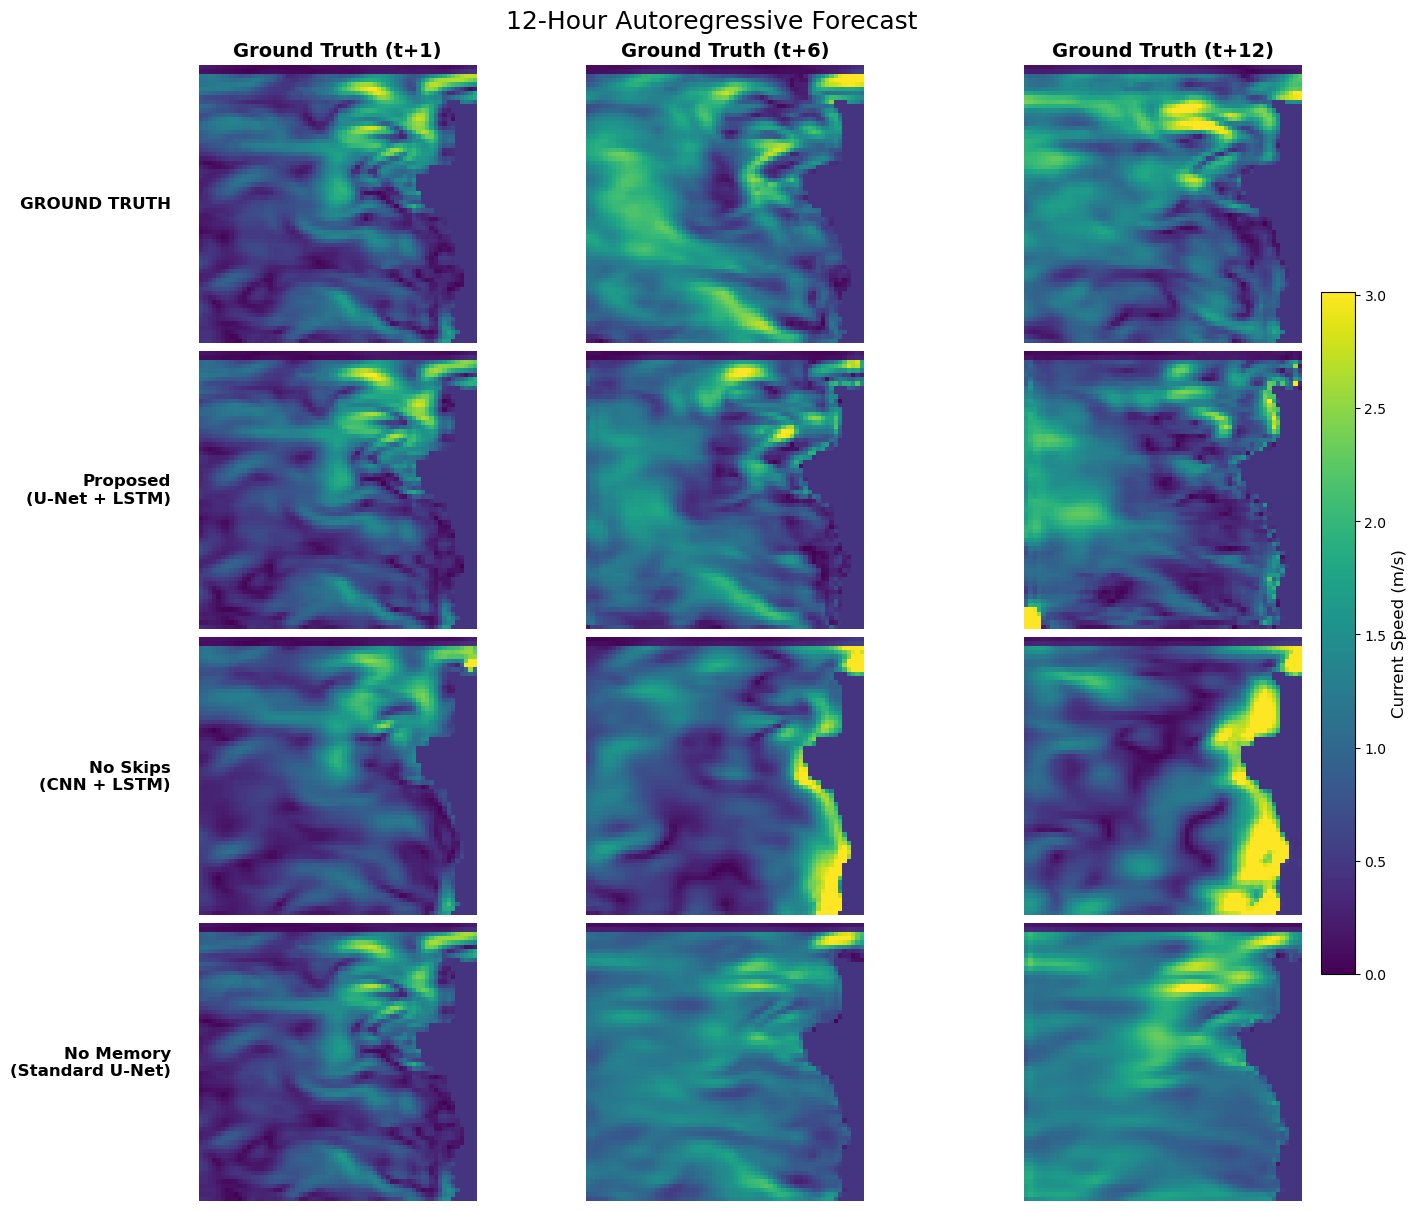

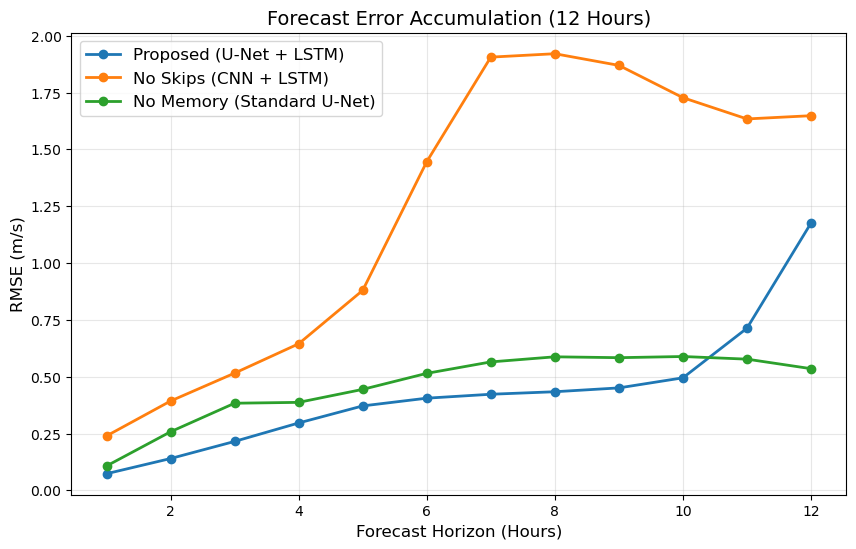

In [8]:
# --- Autoregressive Forecast Function ---
def autoregressive_forecast(model, initial_sequence, steps, stats, mode):
    """
    Performs multi-step forecasting by feeding predictions back as input.
    """
    model.eval()
    current_seq = initial_sequence.clone() # (1, T, 2, H, W)
    predictions = []
    
    with torch.no_grad():
        for _ in range(steps):
            # 1. Prepare Input
            if mode == "standard_unet":
                # Flatten: (1, T, 2, H, W) -> (1, T*2, H, W)
                b, t, c, h, w = current_seq.shape
                inp = current_seq.view(b, t*c, h, w)
            else:
                inp = current_seq
            
            # 2. Predict Next Frame
            out = model(inp) # (1, 4, H, W)
            
            # Extract Mean (u, v) - Keep in Normalized Space for feedback!
            pred_next_norm = out[:, :2].unsqueeze(1) # (1, 1, 2, H, W)
            
            # 3. Store Physical Prediction for Plotting
            pred_phys = invert_zscore(out[0, :2].cpu().numpy(), stats)
            pred_speed = np.sqrt(pred_phys[0]**2 + pred_phys[1]**2)
            predictions.append(pred_speed)
            
            # 4. Update Sequence (Slide Window)
            # Remove oldest frame ([:, 0]), add new prediction to end
            current_seq = torch.cat([current_seq[:, 1:], pred_next_norm], dim=1)
            
    return predictions

# --- Run the Experiment ---
FORECAST_STEPS = 12
start_idx = 100 # Pick a starting point in validation set
initial_x, _ = val_ds[start_idx]

# Ensure Tensor
if isinstance(initial_x, np.ndarray):
    initial_x = torch.from_numpy(initial_x).float().unsqueeze(0).to(DEVICE)
else:
    initial_x = initial_x.float().unsqueeze(0).to(DEVICE)

# Get Ground Truth for next 12 steps
gt_speeds = []
for i in range(FORECAST_STEPS):
    _, y_next = val_ds[start_idx + i] # This fetches the target at t+1+i
    if isinstance(y_next, torch.Tensor): y_next = y_next.cpu().numpy()
    
    y_phys = invert_zscore(y_next, stats)
    gt_speeds.append(np.sqrt(y_phys[0]**2 + y_phys[1]**2))

# Generate Forecasts
model_preds = {}
for mode in MODES:
    if mode in models:
        model_preds[mode] = autoregressive_forecast(models[mode], initial_x, FORECAST_STEPS, stats, mode)

# --- Visualization (Fixed Labels with ax.text) ---
plot_steps = [0, 5, 11] # Indices for t+1, t+6, t+12
cols = ["t+1", "t+6", "t+12"]

# Setup Figure
fig, axes = plt.subplots(len(MODES) + 1, 3, figsize=(14, 12), constrained_layout=True)

# 1. Plot Ground Truth (Top Row)
for i, step in enumerate(plot_steps):
    ax = axes[0, i]
    im = ax.imshow(gt_speeds[step], cmap='viridis', vmin=0, vmax=np.max(gt_speeds[0]))
    ax.set_title(f"Ground Truth ({cols[i]})", fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Label for Top Row
    if i == 0:
        ax.text(-0.1, 0.5, "GROUND TRUTH", transform=ax.transAxes, 
                rotation=0, fontsize=12, fontweight='bold', 
                va='center', ha='right')

# 2. Plot Models (Subsequent Rows)
for row_idx, mode in enumerate(MODES):
    if mode not in model_preds: continue
    
    # Create a nice label with newlines
    label_text = labels[mode].replace(" (", "\n(")
    
    for col_idx, step in enumerate(plot_steps):
        ax = axes[row_idx + 1, col_idx]
        pred = model_preds[mode][step]
        
        im = ax.imshow(pred, cmap='viridis', vmin=0, vmax=np.max(gt_speeds[0]))
        ax.axis('off')
        
        # Add Label to the left of the first column
        if col_idx == 0:
            # (-0.1, 0.5) puts text to the left, centered vertically
            ax.text(-0.1, 0.5, label_text, transform=ax.transAxes, 
                    rotation=0, fontsize=12, fontweight='bold', 
                    va='center', ha='right')

# Add Colorbar
cbar = fig.colorbar(axes[0,0].images[0], ax=axes[:, 2], location='right', shrink=0.6)
cbar.set_label("Current Speed (m/s)", fontsize=12)

plt.suptitle(f"12-Hour Autoregressive Forecast", fontsize=18)
plt.show()

# 3. Error Accumulation Plot (Quantitative)
plt.figure(figsize=(10, 6))
time_axis = np.arange(1, FORECAST_STEPS + 1)

for mode, preds in model_preds.items():
    rmses = []
    for t in range(FORECAST_STEPS):
        rmse = np.sqrt(np.mean((gt_speeds[t] - preds[t])**2))
        rmses.append(rmse)
    plt.plot(time_axis, rmses, marker='o', label=labels[mode], linewidth=2)

plt.title(f"Forecast Error Accumulation ({FORECAST_STEPS} Hours)", fontsize=14)
plt.xlabel("Forecast Horizon (Hours)", fontsize=12)
plt.ylabel("RMSE (m/s)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Evaluating robust statistics on 30 distinct time windows...

=== Robust Forecast Evaluation (Averaged over 30 random starts) ===


,RMSE t+1,RMSE t+6,RMSE t+12
Model,,,
Proposed (U-Net + LSTM),0.32 ± 0.27,0.90 ± 0.53,1.33 ± 0.97
No Skips (CNN + LSTM),0.54 ± 0.38,1.48 ± 0.34,1.59 ± 0.20
No Memory (Standard U-Net),0.19 ± 0.06,0.78 ± 0.36,0.72 ± 0.24


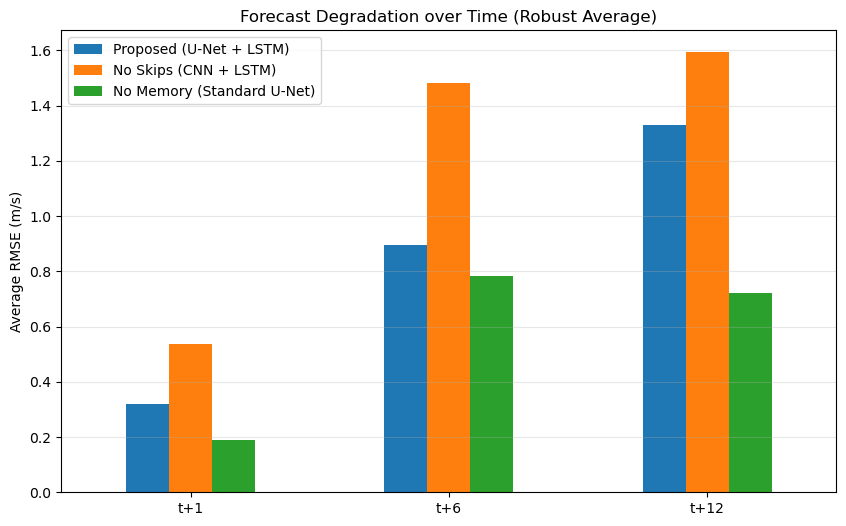

In [9]:
import numpy as np
import pandas as pd
import torch

def evaluate_forecast_horizons(models, dataset, stats, device, 
                               num_samples=20, horizon=12, steps_of_interest=[1, 6, 12]):
    """
    Evaluates forecast stability by averaging errors over multiple starting points
    in the validation dataset.
    """
    
    # Initialize storage for errors
    # structure: errors[mode][step] = [list of errors]
    results_rmse = {mode: {t: [] for t in steps_of_interest} for mode in models}
    results_mae  = {mode: {t: [] for t in steps_of_interest} for mode in models}
    
    # Generate indices: spread them evenly across the dataset
    # ensuring we have room for the forecast horizon at the end
    max_idx = len(dataset) - horizon - 1
    indices = np.linspace(0, max_idx, num_samples, dtype=int)
    
    print(f"Evaluating robust statistics on {num_samples} distinct time windows...")
    
    for idx in indices:
        # 1. Get Initial Sequence (Input)
        X_start, _ = dataset[idx]
        
        # Prepare Tensor
        if isinstance(X_start, np.ndarray):
            curr_seq = torch.from_numpy(X_start).float().unsqueeze(0).to(device)
        else:
            curr_seq = X_start.float().unsqueeze(0).to(device)
            
        # 2. Get Ground Truth for all horizons
        # We need the target frames at t+1, t+6, t+12, etc.
        y_truths = {}
        for t in range(1, horizon + 1):
            _, y_target = dataset[idx + t] # dataset returns (input, target)
            
            # Convert to physical units (Speed magnitude)
            if isinstance(y_target, torch.Tensor): y_target = y_target.cpu().numpy()
            y_phys = invert_zscore(y_target, stats)
            y_speed = np.sqrt(y_phys[0]**2 + y_phys[1]**2)
            y_truths[t] = y_speed

        # 3. Run Forecast for each model
        for mode, model in models.items():
            model.eval()
            seq_t = curr_seq.clone() # specific copy for this model
            
            with torch.no_grad():
                for t in range(1, horizon + 1):
                    # Prepare Input
                    if mode == "standard_unet":
                        b, time, c, h, w = seq_t.shape
                        inp = seq_t.view(b, time*c, h, w)
                    else:
                        inp = seq_t
                    
                    # Predict
                    out = model(inp)
                    
                    # Store Metrics if this is a step of interest (1, 6, 12)
                    if t in steps_of_interest:
                        # Convert prediction to physical units
                        pred_phys = invert_zscore(out[0, :2].cpu().numpy(), stats)
                        pred_speed = np.sqrt(pred_phys[0]**2 + pred_phys[1]**2)
                        
                        # Calculate Error against stored Truth
                        gt_speed = y_truths[t]
                        
                        rmse = np.sqrt(np.mean((gt_speed - pred_speed)**2))
                        mae = np.mean(np.abs(gt_speed - pred_speed))
                        
                        results_rmse[mode][t].append(rmse)
                        results_mae[mode][t].append(mae)
                    
                    # Update Sequence for next step (Autoregression)
                    pred_next_norm = out[:, :2].unsqueeze(1) # Keep normalized for feedback
                    seq_t = torch.cat([seq_t[:, 1:], pred_next_norm], dim=1)

    return results_rmse, results_mae

# --- Run the Robust Evaluation ---
rmse_data, mae_data = evaluate_forecast_horizons(
    models, val_ds, stats, DEVICE, 
    num_samples=30,  # Increase this for more statistical significance
    horizon=12,
    steps_of_interest=[1, 6, 12]
)

# --- Format and Print Table ---
final_rows = []

for mode in MODES:
    if mode not in rmse_data: continue
    
    row = {"Model": labels[mode]}
    for t in [1, 6, 12]:
        # Calculate Mean and Standard Deviation
        mean_rmse = np.mean(rmse_data[mode][t])
        std_rmse = np.std(rmse_data[mode][t])
        
        # Format as "Mean ± Std"
        row[f"RMSE t+{t}"] = f"{mean_rmse:.2f} ± {std_rmse:.2f}"
        
    final_rows.append(row)

df_robust = pd.DataFrame(final_rows).set_index("Model")

print("\n=== Robust Forecast Evaluation (Averaged over 30 random starts) ===")
display(df_robust)

# Optional: Visualize the degradation
# Extract just the means for plotting
plot_data = {}
for mode in MODES:
    if mode in rmse_data:
        plot_data[labels[mode]] = [np.mean(rmse_data[mode][t]) for t in [1, 6, 12]]

df_plot = pd.DataFrame(plot_data, index=["t+1", "t+6", "t+12"])
ax = df_plot.plot(kind='bar', figsize=(10,6), rot=0)
ax.set_ylabel("Average RMSE (m/s)")
ax.set_title("Forecast Degradation over Time (Robust Average)")
ax.grid(axis='y', alpha=0.3)
plt.show()

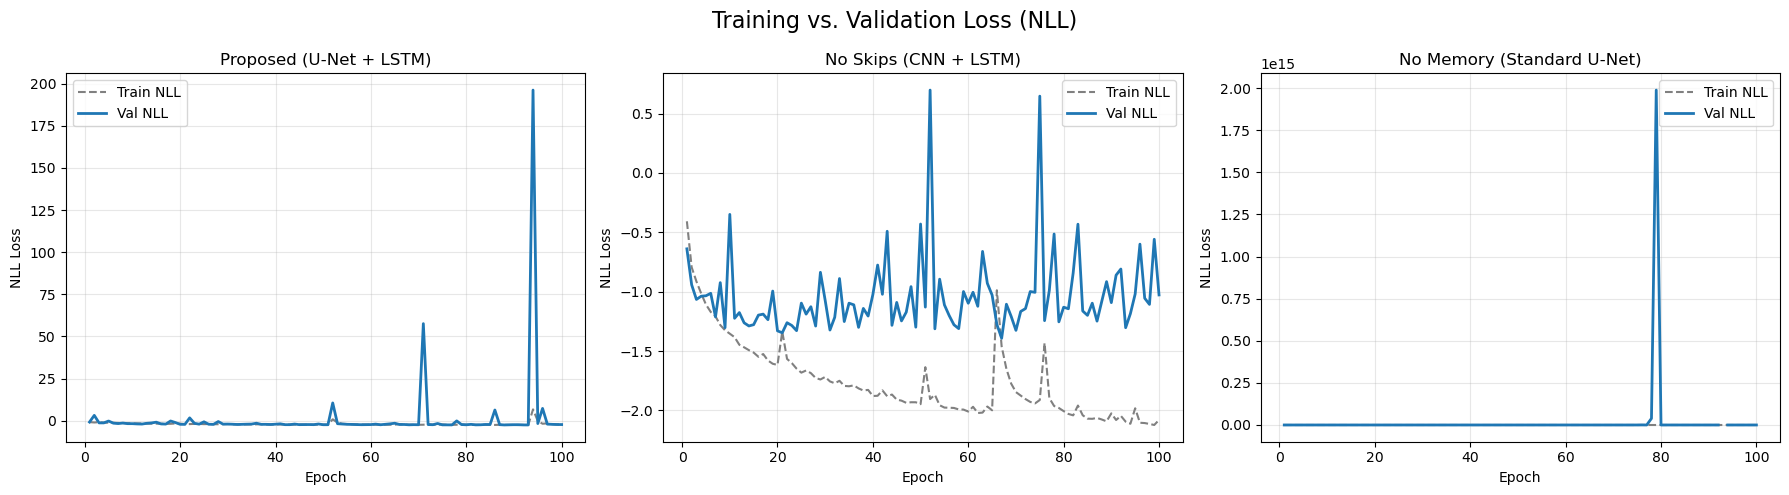

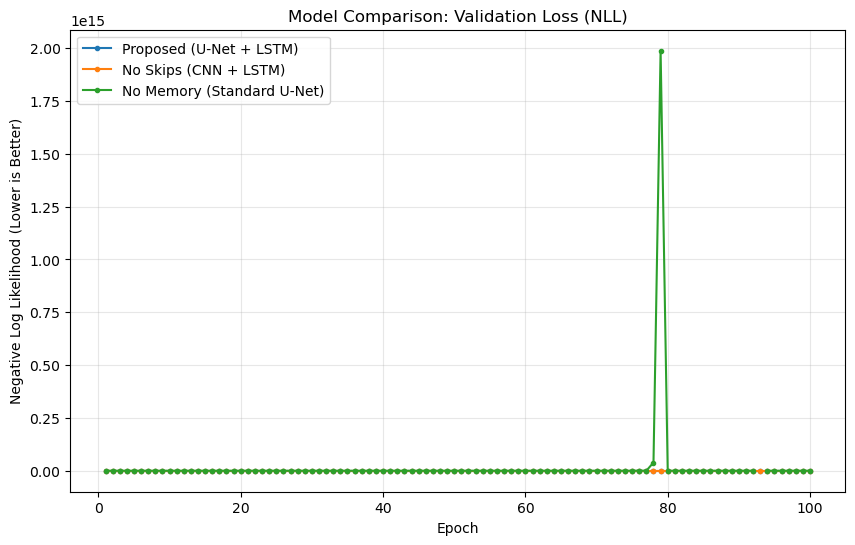

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# labels mapping (if not already defined)
labels = {
    "unet_convlstm": "Proposed (U-Net + LSTM)",
    "cnn_convlstm": "No Skips (CNN + LSTM)",
    "standard_unet": "No Memory (Standard U-Net)"
}

# --- PLOT 1: Train vs Val Loss per Model ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, mode in enumerate(MODES):
    if mode not in results: continue
    
    df = pd.DataFrame(results[mode])
    ax = axes[i]
    
    # Plot Train (dashed) and Val (solid)
    ax.plot(df['epoch'].values, df['train_loss'].values, label='Train NLL', linestyle='--', color='gray')
    ax.plot(df['epoch'].values, df['val_nll'].values, label='Val NLL', linewidth=2, color='tab:blue')
    
    ax.set_title(labels[mode])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("NLL Loss")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Training vs. Validation Loss (NLL)", fontsize=16)
plt.tight_layout()
plt.show()

# --- PLOT 2: Compare Validation Loss Across Models ---
plt.figure(figsize=(10, 6))

for mode in MODES:
    if mode in results:
        df = pd.DataFrame(results[mode])
        plt.plot(df['epoch'].values, df['val_nll'].values, label=labels[mode], marker='.')

plt.title("Model Comparison: Validation Loss (NLL)")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood (Lower is Better)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_5166/2535606631.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)


Loaded model.


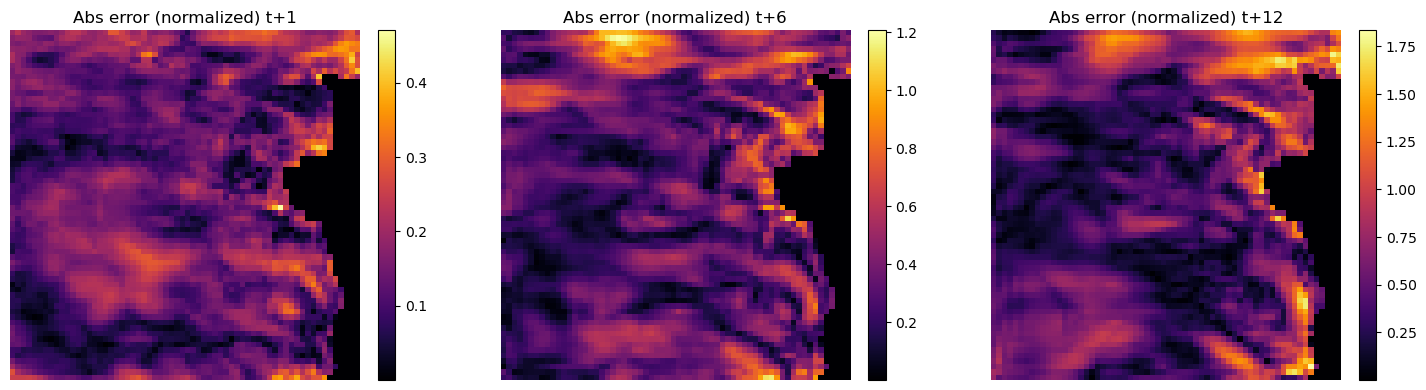

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load model
# -----------------------------
model_path = "experiments_outputs/unet_convlstm_weights.pth"

model = ThesisVariant(
    in_ch=2,
    out_ch=4,
    base_ch=32,
    lstm_ch=128,
    seq_len=3,
    mode="unet_convlstm"
).to(device)

state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.eval()

print("Loaded model.")

# -----------------------------
# Pick validation index
# -----------------------------
idx = 0
steps_of_interest = [1, 6, 12]
horizon = 12

X0, _ = val_ds[idx]
seq = X0.unsqueeze(0).to(device)  # (1,T,2,H,W)

# collect ground truth targets
gt = {}
for t in steps_of_interest:
    _, y = val_ds[idx + t]
    gt[t] = y.numpy()   # (2,H,W)

# -----------------------------
# Autoregressive prediction
# -----------------------------
preds = {}
seq_t = seq.clone()

with torch.no_grad():
    for t in range(1, horizon + 1):
        out = model(seq_t)           # (1,4,H,W)
        pred_mean = out[:, :2]       # (1,2,H,W)

        if t in steps_of_interest:
            preds[t] = pred_mean[0].cpu().numpy()

        pred_next = pred_mean.unsqueeze(1)
        seq_t = torch.cat([seq_t[:, 1:], pred_next], dim=1)

# -----------------------------
# Plot absolute error
# -----------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, t in zip(axs, steps_of_interest):
    abs_err = np.abs(preds[t] - gt[t])  # (2,H,W)
    abs_err_mag = abs_err.mean(axis=0)  # average over u,v

    im = ax.imshow(abs_err_mag, cmap="inferno")
    ax.set_title(f"Abs error (normalized) t+{t}")
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
